# Classification Project: Emily Gomez

Taking the Apprentice Chef Dataset made for this project, I am building a classification model to predict cross-sell success(CSS) and to identify the variables that are important in CSS. The success is a customer for the mealplans who also order the wine and will be indicated as a 1 on a 1,0 variable. 

Results are checked by splitting data into training and testing data for the given model. AUC (area under the curve) scores were found to measure the model's performance. The training and testing scores were compared to limit overfitting and underfitting with a goal of having them within 5% of each other.

In [1]:
# Import Packages for visualizations, computations, data analysis, and models.
# Set designated seed specified by the professor to replicate results.
# Set test size to split the data into the training/testing sets.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

SEED = 222
pct_test = 0.25

C:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import Data

file = 'C:/Users/egome/Documents/Hult/Machine Learning/A2_Apprentice_Chef_Dataset.xlsx'
original_df = pd.read_excel(file)

## Charting Importance of Features
Create a function that plots a bar chart to visualize which features were most significant in the model. 

In [3]:
# Create plot_feature_importances

def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Feature_Importance.png')

## Initial Exploration
Run an initial exploration of the data

In [4]:
# Exploratory information

print(original_df.head(n=5))
print(original_df.info())
print(original_df.describe())

   REVENUE  CROSS_SELL_SUCCESS                              NAME                                     EMAIL FIRST_NAME  FAMILY_NAME  TOTAL_MEALS_ORDERED  UNIQUE_MEALS_PURCH  CONTACTS_W_CUSTOMER_SERVICE  PRODUCT_CATEGORIES_VIEWED  AVG_TIME_PER_SITE_VISIT  MOBILE_NUMBER  CANCELLATIONS_BEFORE_NOON  CANCELLATIONS_AFTER_NOON  TASTES_AND_PREFERENCES  MOBILE_LOGINS  PC_LOGINS  WEEKLY_PLAN  EARLY_DELIVERIES  LATE_DELIVERIES  PACKAGE_LOCKER  REFRIGERATED_LOCKER  FOLLOWED_RECOMMENDATIONS_PCT  AVG_PREP_VID_TIME  LARGEST_ORDER_SIZE  MASTER_CLASSES_ATTENDED  MEDIAN_MEAL_RATING  AVG_CLICKS_PER_VISIT  TOTAL_PHOTOS_VIEWED
0   1880.0                   1                      Addam Osgrey                 addam.osgrey@passport.com      Addam       Osgrey                  118                   4                            7                          5                    86.00              1                          2                         1                       0              6          2            8    

## Splitting Email Addresses
Divide the email addresses from each customer into **professional email** addresses, **personal email** addresses, and **junk email** addresses. This will be used later to analyze whether or not the type of email address provided impacts the cross_sell_success. 

In [5]:
# Splitting email addresses into categories

email_lst = [] # empty list to put email splits in 
for index, col in original_df.iterrows(): # goes through all rows through the email column
    split_email = original_df.loc[index, 'EMAIL'].split(sep = '@') # separates at the '@'
    email_lst.append(split_email) # adds the splits to the list

email_df = pd.DataFrame(email_lst) # creates dataframe from the list created
email_df.columns = ['NAME', 'EMAIL_DOMAIN'] # names the columns in the dataframe
original_df = pd.concat([original_df, email_df.loc[:, 'EMAIL_DOMAIN']], # joins the dataframe to the original_df
                       axis=1)

# creates the lists of domains in each category based on case study
prof_email = ['@mmm.com','@amex.com', '@apple.com', '@boeing.com', '@caterpillar.com', '@chevron.com', '@cisco.com', 
              '@cocacola.com', '@disney.com','@dupont.com', '@exxon.com', '@ge.org', '@goldmansacs.com','@homedepot.com', 
              '@ibm.com', '@intel.com', '@jnj.com','@jpmorgan.com', '@mcdonalds.com', '@merck.com', '@microsoft.com',
              '@nike.com', '@pfizer.com', '@pg.com', '@travelers.com','@unitedtech.com', '@unitedhealth.com', 
              '@verizon.com','@visa.com', '@walmart.com']
pers_email = ['@gmail.com', '@yahoo.com', '@protonmail.com']
junk_email = ['@me.com', '@aol.com', '@hotmail.com', '@live.com','@msn.com', '@passport.com']

placeholder_lst = [] # empty list to put the domains in 
for domain in original_df['EMAIL_DOMAIN']: # goes over all domains to classify them into the categories
    if '@' + domain in prof_email:
        placeholder_lst.append('PROFESSIONAL') # populates empty list with professional 
    elif '@' + domain in pers_email:
        placeholder_lst.append('PERSONAL') # populates empty list with personal
    elif '@' + domain in junk_email:
        placeholder_lst.append('JUNK') # populates empty list with junk
    else:
        placeholder_lst.append('UNKNOWN') # catch errors
    
original_df['DOMAIN_GROUP'] = pd.Series(placeholder_lst) # takes the populated list and adds it to the dataframe under domain_group column
original_df['DOMAIN_GROUP'].value_counts() # counts the number of entries in each category

PERSONAL        861
PROFESSIONAL    696
JUNK            389
Name: DOMAIN_GROUP, dtype: int64

## Email Dummy Variables
Create dummy variables for the 3 types of emails and drop the original data.

In [6]:
# Creating email dummies

email_dummies = pd.get_dummies(original_df['DOMAIN_GROUP']) # creates dummy variables for the 3 categories
original_df = original_df.drop('DOMAIN_GROUP', axis=1) # drops the domain_group column
original_df = original_df.join(email_dummies) # joins the dummy columns (1 for each category for a total of 3)

## Tastes and Preferences & Followed Recommendations Pct
Create a varible that identifies when 'Tastes and Preferences' are entered and the customer follows the recommendations greater than 40% of the time. 

The thought behind this was that if tastes and preferences information is entered and utilized correctly, it should lead to better recommendations that people would like to use. Once the consumer feels he or she can trust the recommendations, it could lead to more CSS. 

In [7]:
# Creating a variable: recommendations x tastes and preferences to see if t&p increases the recom. power
    
def rec_on_tastes(data):
    value = data['FOLLOWED_RECOMMENDATIONS_PCT']*data['TASTES_AND_PREFERENCES']
    if value < 40 and value != 0:
        return 1
    else:
        return 0

original_df['REC_ON_TASTES'] = original_df.apply(rec_on_tastes, axis = 1)

## Variable Histograms
Visualize each variable's data. This will be used in feature engineering to set **threshholds** and indicate **outliers.**

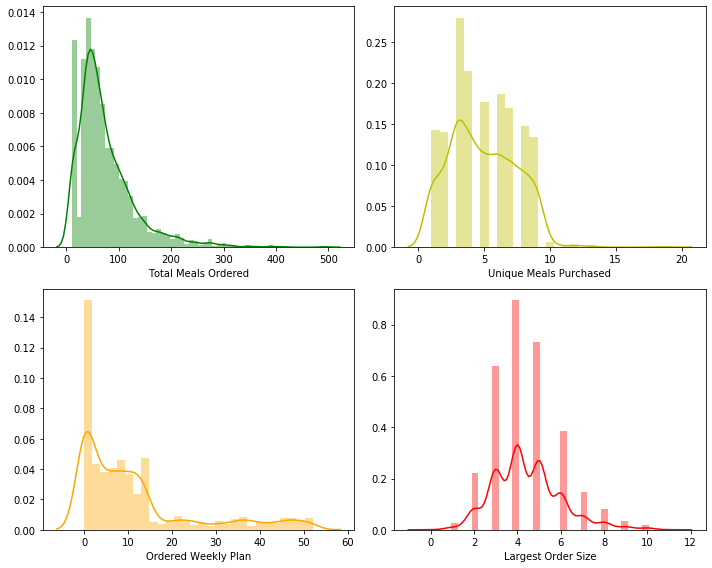

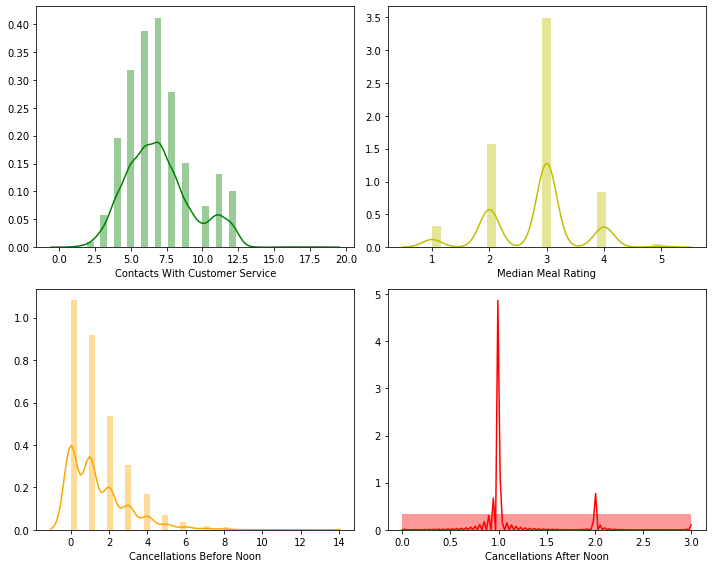

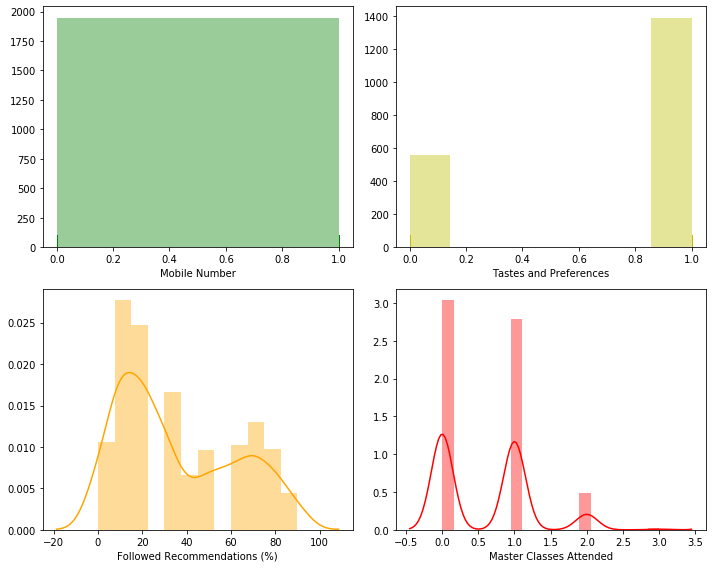

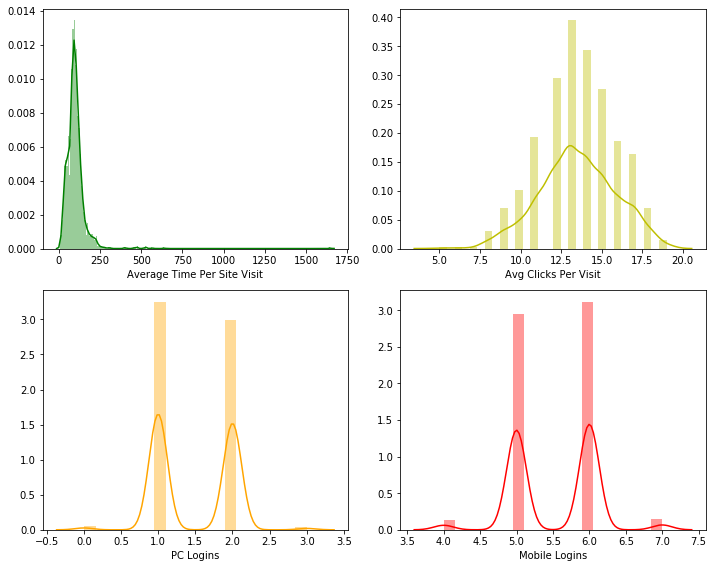

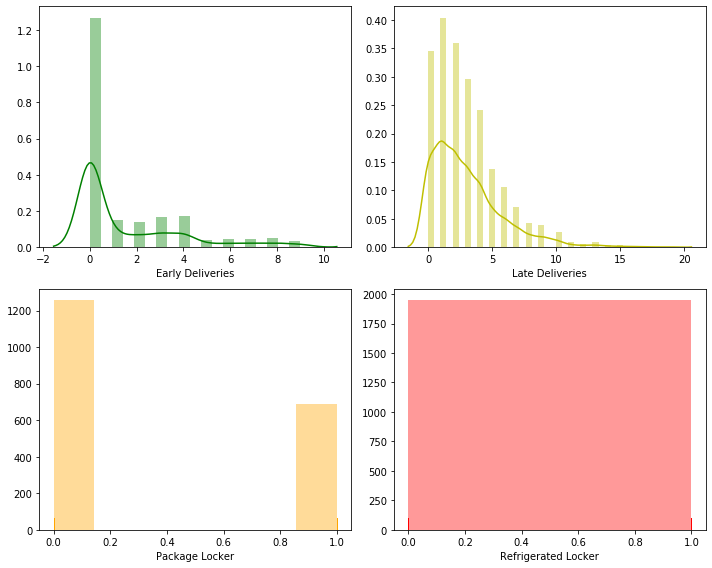

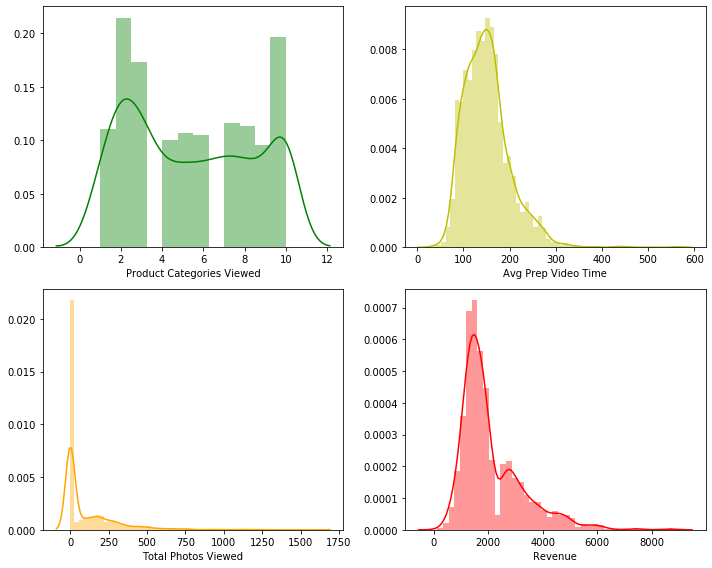

In [8]:
########################
# Visual EDA (Histograms)
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['TOTAL_MEALS_ORDERED'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Total Meals Ordered')

########################

plt.subplot(2, 2, 2)
sns.distplot(original_df['UNIQUE_MEALS_PURCH'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Unique Meals Purchased')

########################

plt.subplot(2, 2, 3)
sns.distplot(original_df['WEEKLY_PLAN'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Ordered Weekly Plan')

########################
plt.subplot(2, 2, 4)
sns.distplot(original_df['LARGEST_ORDER_SIZE'],
             bins  = 'fd',
             color = 'r')
plt.xlabel('Largest Order Size')
plt.tight_layout()
plt.savefig('Original_df Histograms 1 of 6.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['CONTACTS_W_CUSTOMER_SERVICE'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Contacts With Customer Service')

########################

plt.subplot(2, 2, 2)
sns.distplot(original_df['MEDIAN_MEAL_RATING'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Median Meal Rating')

########################

plt.subplot(2, 2, 3)
sns.distplot(original_df['CANCELLATIONS_BEFORE_NOON'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Cancellations Before Noon')

########################

plt.subplot(2, 2, 4)
sns.distplot(original_df['CANCELLATIONS_AFTER_NOON'],
             bins  = 'fd',
             color = 'r')
plt.xlabel('Cancellations After Noon')
plt.tight_layout()
plt.savefig('original_df Histograms 2 of 6.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['MOBILE_NUMBER'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'g')
plt.xlabel('Mobile Number')

########################

plt.subplot(2, 2, 2)
sns.distplot(original_df['TASTES_AND_PREFERENCES'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'y')
plt.xlabel('Tastes and Preferences')

########################

plt.subplot(2, 2, 3)
sns.distplot(original_df['FOLLOWED_RECOMMENDATIONS_PCT'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Followed Recommendations (%)')

########################

plt.subplot(2, 2, 4)
sns.distplot(original_df['MASTER_CLASSES_ATTENDED'],
             bins  = 'fd',
             color = 'r')
plt.xlabel('Master Classes Attended')
plt.tight_layout()
plt.savefig('original_df Histograms 3 of 6.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['AVG_TIME_PER_SITE_VISIT'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Average Time Per Site Visit')

########################

plt.subplot(2, 2, 2)
sns.distplot(original_df['AVG_CLICKS_PER_VISIT'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Avg Clicks Per Visit')

########################

plt.subplot(2, 2, 3)
sns.distplot(original_df['PC_LOGINS'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('PC Logins')

########################

plt.subplot(2, 2, 4)
sns.distplot(original_df['MOBILE_LOGINS'],
             bins  = 'fd',
             color = 'r')
plt.xlabel('Mobile Logins')
plt.tight_layout()
plt.savefig('original_df Histograms 4 of 6.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['EARLY_DELIVERIES'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Early Deliveries')

########################

plt.subplot(2, 2, 2)
sns.distplot(original_df['LATE_DELIVERIES'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Late Deliveries')

########################

plt.subplot(2, 2, 3)
sns.distplot(original_df['PACKAGE_LOCKER'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.xlabel('Package Locker')

########################

plt.subplot(2, 2, 4)
sns.distplot(original_df['REFRIGERATED_LOCKER'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('Refrigerated Locker')
plt.tight_layout()
plt.savefig('App_Chef Histograms 5 of 6.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['PRODUCT_CATEGORIES_VIEWED'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Product Categories Viewed')

########################

plt.subplot(2, 2, 2)
sns.distplot(original_df['AVG_PREP_VID_TIME'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Avg Prep Video Time')

########################

plt.subplot(2, 2, 3)
sns.distplot(original_df['TOTAL_PHOTOS_VIEWED'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Total Photos Viewed')

########################

plt.subplot(2, 2, 4)
sns.distplot(original_df['REVENUE'],
            bins = 'fd',
            color= 'r')
plt.xlabel('Revenue')
plt.tight_layout()
plt.savefig('original_df Histograms 6 of 6.png')
plt.show()

## Identifying Points In The Graphs To Use In Feature Engineering
From these graphs, I identified inflated zeros such as in 'Total Photos Viewed', outliers such as >230 in 'Avg Prep Video Time', and changes in trends such as the bimodal graph in 'Followed Recommendations Pct'.

These will be used later during feature engineering.

## Value Counts
Create a value count to see if there is a clear pattern between binomial/boolean variables. 

When the [variable] is present (1), what are the counts of Cross Sell Success and Failure?
When the [variable] is not present (0), what are the counts of Cross Sell Success and Failure?
Is there a high pct of CSS when [variable] is present or not present?

Is [variable] possibly a good predictor or factor in CSS?

In [9]:
# Value Counts

f_mn = (original_df[original_df['MOBILE_NUMBER']==0]['CROSS_SELL_SUCCESS'].value_counts())
s_mn =(original_df[original_df['MOBILE_NUMBER']==1]['CROSS_SELL_SUCCESS'].value_counts())
print(f"""
*Mobile Number*
MN = 1, CSS counts: 
{s_mn}, 
MN = 0, CSS counts: 
{f_mn}, 
1/0 :
PCT CSS with MN:    {int(s_mn[[1]])/(int(s_mn[[1]])+int(s_mn[[0]]))*100}
PCT CSS without MN: {int(f_mn[[1]])/(int(f_mn[[1]])+int(f_mn[[0]]))*100}
""")

f_tp = (original_df[original_df['TASTES_AND_PREFERENCES']==0]['CROSS_SELL_SUCCESS'].value_counts())
s_tp = (original_df[original_df['TASTES_AND_PREFERENCES']==1]['CROSS_SELL_SUCCESS'].value_counts())
print(f"""
*Tastes and Preferences*
TP = 1, CSS counts: 
{s_tp}, 
TP = 0, CSS counts: 
{f_tp}, 
1/0 :
PCT CSS with TP:    {int(s_tp[[1]])/(int(s_tp[[1]])+int(s_tp[[0]]))*100}
PCT CSS without TP: {int(f_tp[[1]])/(int(f_tp[[1]])+int(f_tp[[0]]))*100}
""")

f_pl =(original_df[original_df['PACKAGE_LOCKER']==0]['CROSS_SELL_SUCCESS'].value_counts())
s_pl =(original_df[original_df['PACKAGE_LOCKER']==1]['CROSS_SELL_SUCCESS'].value_counts())
print(f"""
*Package Locker*
PL = 1, CSS counts: 
{s_pl}, 
PL = 0, CSS counts: 
{f_pl}, 
1/0 :
PCT CSS with PL:    {int(s_pl[[1]])/(int(s_pl[[1]])+int(s_pl[[0]]))*100}
PCT CSS without PL: {int(f_pl[[1]])/(int(f_pl[[1]])+int(f_pl[[0]]))*100}
""")

f_rl = (original_df[original_df['REFRIGERATED_LOCKER']==0]['CROSS_SELL_SUCCESS'].value_counts())
s_rl =(original_df[original_df['REFRIGERATED_LOCKER']==1]['CROSS_SELL_SUCCESS'].value_counts())
print(f"""
*Refrigerated Locker*
RL = 1, CSS counts: 
{s_rl}, 
RL = 0, CSS counts: 
{f_rl}, 
1/0 :
PCT CSS with RL:    {int(s_rl[[1]])/(int(s_rl[[1]])+int(s_rl[[0]]))*100}
PCT CSS without RL: {int(f_rl[[1]])/(int(f_rl[[1]])+int(f_rl[[0]]))*100}
""")

#
f_rt = (original_df[original_df['REC_ON_TASTES']==0]['CROSS_SELL_SUCCESS'].value_counts())
s_rt =(original_df[original_df['REC_ON_TASTES']==1]['CROSS_SELL_SUCCESS'].value_counts())
print(f"""
*Recommendations on Tastes*
RT = 1, CSS counts: 
{s_rt}, 
RT = 0, CSS counts: 
{f_rt}, 
Pct CSS with RT:    {int(s_rt[[1]])/(int(s_rt[[1]])+int(s_rt[[0]]))*100}
PCT CSS without RT: {int(f_rt[[1]])/(int(f_rt[[1]])+int(f_rt[[0]]))*100}
""")


*Mobile Number*
MN = 1, CSS counts: 
1    1190
0     518
Name: CROSS_SELL_SUCCESS, dtype: int64, 
MN = 0, CSS counts: 
1    131
0    107
Name: CROSS_SELL_SUCCESS, dtype: int64, 
1/0 :
PCT CSS with MN:    69.67213114754098
PCT CSS without MN: 55.04201680672269


*Tastes and Preferences*
TP = 1, CSS counts: 
1    977
0    413
Name: CROSS_SELL_SUCCESS, dtype: int64, 
TP = 0, CSS counts: 
1    344
0    212
Name: CROSS_SELL_SUCCESS, dtype: int64, 
1/0 :
PCT CSS with TP:    70.28776978417267
PCT CSS without TP: 61.87050359712231


*Package Locker*
PL = 1, CSS counts: 
1    488
0    203
Name: CROSS_SELL_SUCCESS, dtype: int64, 
PL = 0, CSS counts: 
1    833
0    422
Name: CROSS_SELL_SUCCESS, dtype: int64, 
1/0 :
PCT CSS with PL:    70.62228654124458
PCT CSS without PL: 66.37450199203188


*Refrigerated Locker*
RL = 1, CSS counts: 
1    169
0     51
Name: CROSS_SELL_SUCCESS, dtype: int64, 
RL = 0, CSS counts: 
1    1152
0     574
Name: CROSS_SELL_SUCCESS, dtype: int64, 
1/0 :
PCT CSS with RL: 

## Value Counts Analysis

When comparing the percentages of CSS with and without the variable, large differences would suggest the variable's presence impacting the CSS.

The largest difference between the % CSS when the variable is 1 and 0 is found with the 'Recommendations on Tastes'. This variable is recommendations being followed >= 40% of the time when Tastes and Preferences are entered.

It appears that there is significantly more success when 'Recommendations on Tastes' is not present. 

## Feature Engineering
- Set outlier thresholds and breaks.
- Incorporate them into the model to create new features.
- Creating significant features helps increase a model's performance. 

In [10]:
# Feature Engineering

tot_meals_ord_hi = 200
avg_time_site_vis_hi = 260
ord_wk_plan_hi = 13
rev_hi = 4500
cont_cus_ser_chg_at = 10 # trend change
fol_rec_chg_at = 35 # trend change, maybe
prod_cat_vw_chg_at = 5 # trend chang
large_ord_chg_at = 3 # changes trend
tot_phot_vw_hi = 640 # cut tail # MAYBE
avg_prep_vid_hi = 250 # change
ord_weekly_pln_change_at = 0 
early_del_change_at = 0 
pc_logins_change_hi = 1.5
avg_clicks_change_lo = 7

In [11]:
# Setting outliers and thresholds 

# TOTAL_MEALS_ORDERED
original_df['out_TOT_MEALS'] = 0
condition_hi = original_df.loc[0:, 'out_TOT_MEALS'][original_df['TOTAL_MEALS_ORDERED'] > tot_meals_ord_hi]

original_df['out_TOT_MEALS'].replace(to_replace = condition_hi,
                                      value = 1,
                                      inplace = True)
# REVENUE
original_df['out_REVENUE'] = 0
condition_hi = original_df.loc[0:, 'out_REVENUE'][original_df['REVENUE'] > rev_hi]

original_df['out_REVENUE'].replace(to_replace = condition_hi,
                                      value = 1,
                                      inplace = True)
# AVG_TIME_PER_SITE_VISIT
original_df['out_AVG_TIME_SITE'] = 0
condition_hi = original_df.loc[0:, 'out_AVG_TIME_SITE'][original_df['AVG_TIME_PER_SITE_VISIT'] > avg_time_site_vis_hi]

original_df['out_AVG_TIME_SITE'].replace(to_replace = condition_hi,
                                      value = 1,
                                      inplace = True)
# AVG_PREP_VID_TIME
original_df['out_AVG_PREP_TIME'] = 0
condition_hi = original_df.loc[0:, 'out_AVG_PREP_TIME'][original_df['AVG_PREP_VID_TIME'] > avg_prep_vid_hi]

original_df['out_AVG_PREP_TIME'].replace(to_replace = condition_hi,
                                      value = 1,
                                      inplace = True)
# WEEKLY_PLAN
original_df['out_WKLY_PLAN'] = 0
condition_hi = original_df.loc[0:, 'out_WKLY_PLAN'][original_df['WEEKLY_PLAN'] > ord_wk_plan_hi]

original_df['out_WKLY_PLAN'].replace(to_replace = condition_hi,
                                      value = 1,
                                      inplace = True)
# change CONTACTS_W_CUSTOMER_SERVICE
original_df['change_CCS'] = 0
condition = original_df.loc[0:, 'change_CCS'][original_df['CONTACTS_W_CUSTOMER_SERVICE'] > cont_cus_ser_chg_at]

original_df['change_CCS'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)
########## change FOLLOWED_RECOMMENDATIONS_PCT #############
original_df['change_FLD_REC_PCT'] = 0
condition = original_df.loc[0:, 'change_FLD_REC_PCT'][original_df['FOLLOWED_RECOMMENDATIONS_PCT'] > fol_rec_chg_at]

original_df['change_FLD_REC_PCT'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)
########## change PRODUCT_CATEGORIES_VIEWED #############
original_df['change_PRD_CAT_VIEW'] = 0
condition = original_df.loc[0:, 'change_PRD_CAT_VIEW'][original_df['PRODUCT_CATEGORIES_VIEWED'] > prod_cat_vw_chg_at]

original_df['change_PRD_CAT_VIEW'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)#
########## change LARGEST_ORDER_SIZE #############
original_df['change_LARGE_ORDER'] = 0
condition = original_df.loc[0:, 'change_LARGE_ORDER'][original_df['LARGEST_ORDER_SIZE'] > large_ord_chg_at]

original_df['change_LARGE_ORDER'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)
########## change TOTAL_PHOTOS_VIEWED #############
original_df['change_TOTAL_PHOTOS'] = 0
condition = original_df.loc[0:, 'change_TOTAL_PHOTOS'][original_df['TOTAL_PHOTOS_VIEWED'] > tot_phot_vw_hi]

original_df['change_TOTAL_PHOTOS'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)
########## change WEEKLY PLAN #############
original_df['change_WEEKLY_PLAN'] = 0
condition = original_df.loc[0:, 'change_WEEKLY_PLAN'][original_df['WEEKLY_PLAN'] == ord_weekly_pln_change_at] # zero inflated

original_df['change_WEEKLY_PLAN'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)
########## change EARLY DELIVERIES #############
original_df['change_EARLY_DELIVERIES'] = 0
condition = original_df.loc[0:, 'change_EARLY_DELIVERIES'][original_df['EARLY_DELIVERIES'] == early_del_change_at] # zero inflated

original_df['change_EARLY_DELIVERIES'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)
########## change AVG_CLICKS_PER_VISIT #############
original_df['change_AVG_CLICKS_PER_VIS'] = 0
condition = original_df.loc[0:, 'change_AVG_CLICKS_PER_VIS'][original_df['AVG_CLICKS_PER_VISIT'] < avg_clicks_change_lo]

original_df['change_AVG_CLICKS_PER_VIS'].replace(to_replace = condition, 
                                    value = 1, 
                                    inplace = True)

## Correlations
Run correlations between Cross_Sell_Success(CSS) and all variables to see which variables are highly correlated. Highly correlated variables may help predict the CSS better.

In [12]:
# Correlations
df_corr = original_df.corr().round(3)
df_corr['CROSS_SELL_SUCCESS'].sort_values()

REC_ON_TASTES                  -0.354
JUNK                           -0.281
CANCELLATIONS_AFTER_NOON       -0.054
out_TOT_MEALS                  -0.052
PC_LOGINS                      -0.051
AVG_CLICKS_PER_VISIT           -0.035
change_TOTAL_PHOTOS            -0.016
change_CCS                     -0.013
out_WKLY_PLAN                  -0.007
out_AVG_TIME_SITE              -0.006
change_PRD_CAT_VIEW            -0.006
WEEKLY_PLAN                    -0.005
UNIQUE_MEALS_PURCH              0.001
REVENUE                         0.005
PRODUCT_CATEGORIES_VIEWED       0.005
TOTAL_MEALS_ORDERED             0.006
change_EARLY_DELIVERIES         0.006
change_AVG_CLICKS_PER_VIS       0.007
LATE_DELIVERIES                 0.007
TOTAL_PHOTOS_VIEWED             0.010
AVG_TIME_PER_SITE_VISIT         0.011
out_REVENUE                     0.014
EARLY_DELIVERIES                0.015
change_WEEKLY_PLAN              0.019
LARGEST_ORDER_SIZE              0.022
change_LARGE_ORDER              0.026
AVG_PREP_VID

## Correlation Analysis

Variables with a stronger negative correlation with CSS include using a **junk** email address and **recommendations followed with tastes and preferences present**. 

Variables with a stronger positive correlation with CSS include the engineered **change in followed recommendations pct**, **following recommendations pct**, using a **professional** email address, **cancellations before noon**, and having a **mobile number**.

## Setting up test/train splits
Variable lists
- Create a list of all variables to use in models that require a full set. 
- Create a list of significant varibales (significance is found using the logistic regression model below).
- Create the datasets for each list of variables. 

Scaling and Splitting
- Create scaled data for the full and significant variable lists.
- Create scaled and unscaled dataset splits using the random_state 'SEED' and test_size 'pct_test' set at the beginning.

In [13]:
# Setting up variables
X_var_full = ['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE','PRODUCT_CATEGORIES_VIEWED', 
'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 
'TASTES_AND_PREFERENCES', 'MOBILE_LOGINS', 'PC_LOGINS','WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 
'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 
'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED',  
'PERSONAL', 'PROFESSIONAL', 'out_TOT_MEALS', 'out_REVENUE', 'out_AVG_TIME_SITE', 'out_WKLY_PLAN',
'change_CCS', 'change_FLD_REC_PCT','change_PRD_CAT_VIEW','change_TOTAL_PHOTOS', 'out_AVG_PREP_TIME',
'change_AVG_CLICKS_PER_VIS', 'change_EARLY_DELIVERIES', 'change_WEEKLY_PLAN', 'REC_ON_TASTES', 
'change_PRD_CAT_VIEW', 'change_LARGE_ORDER']

X_var_sig = ['TOTAL_MEALS_ORDERED','MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON', 'TASTES_AND_PREFERENCES','PC_LOGINS',
'EARLY_DELIVERIES','FOLLOWED_RECOMMENDATIONS_PCT','PERSONAL','PROFESSIONAL','out_TOT_MEALS', 'out_AVG_PREP_TIME', 
'REC_ON_TASTES', 'change_PRD_CAT_VIEW', 'change_LARGE_ORDER']

original_sig_data = original_df.loc[ : , X_var_sig]
original_df_data = original_df.loc[ : , X_var_full]
original_df_target = original_df.loc[ : , 'CROSS_SELL_SUCCESS']

In [14]:
# Creating the split for the unscaled full data for logit model (used to choose significant variables for 'X_var_sig')
X_train, X_test, y_train, y_test = train_test_split(
original_df_data,
original_df_target,
test_size = pct_test,
random_state = SEED,
stratify = original_df_target)

original_log_train = pd.concat([X_train, y_train], axis = 1)

In [15]:
# Scaling full data
scaler = StandardScaler() # instantiating StandardScaler()
scaler.fit(original_df_data) # fit the data
X_scaled = scaler.transform(original_df_data) # transforming the data
X_scaled_df = pd.DataFrame(X_scaled) # converting to a dataframe
X_scaled_df.columns = original_df_data.columns # importing column names

# Scaling rel data
scaler = StandardScaler() # instantiating StandardScaler()
scaler.fit(original_sig_data) # fit the data
X_scaled_rel = scaler.transform(original_sig_data) # transforming the data
X_scaled_rel_df = pd.DataFrame(X_scaled_rel) # converting to a dataframe
X_scaled_rel_df.columns = original_sig_data.columns # importing column names

In [16]:
# Creating the split for scaled full data
X_train_fulls, X_test_fulls, y_train_fulls, y_test_fulls = train_test_split(
X_scaled_df,
original_df_target,
test_size = pct_test,
random_state = SEED,
stratify = original_df_target)

In [17]:
# Creating the split for scaled relevant data
X_train_rels, X_test_rels, y_train_rels, y_test_rels = train_test_split(
X_scaled_rel_df,
original_df_target,
test_size = pct_test,
random_state = SEED,
stratify = original_df_target)

### Logistic Regression Model
This is used to choose significant variables by taking an insignificant variable out one at a time and rerunning the model, starting with the least significant variables.

In [18]:
# Logistic regression model without JUNK
log_mod = smf.logit(formula = """ CROSS_SELL_SUCCESS ~
TOTAL_MEALS_ORDERED + MOBILE_NUMBER + CANCELLATIONS_BEFORE_NOON + TASTES_AND_PREFERENCES + 
PC_LOGINS + EARLY_DELIVERIES + FOLLOWED_RECOMMENDATIONS_PCT + PERSONAL + PROFESSIONAL +
out_TOT_MEALS + out_AVG_PREP_TIME + REC_ON_TASTES """, 
                   data = original_log_train)
results_full = log_mod.fit()
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.398617
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1446
Method:                           MLE   Df Model:                           12
Date:                Sat, 04 Apr 2020   Pseudo R-squ.:                  0.3652
Time:                        12:38:38   Log-Likelihood:                -581.58
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                1.699e-135
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -3.0421      0.394     -7.721      0.000      -3.814      -2.270
TOTAL_MEALS_ORDERED              0.0036      0.002      2.025      0.043       0.000       0.007
MOBILE_NUMBER                    0.7242      0.214      3.383      0.001       0.305       1.144
CANCELLATIONS_BEFORE_NOON        0.2563      0.051      5.048      0.000       0.157       0.356
TASTES_AND_PREFERENCES           2.0155      0.253      7.974      0.000       1.520       2.511
PC_LOGINS                       -0.2543      0.136     -1.876      0.061      -0.520       0.011
EARLY_DELIVERIES                 0.0598      0.032      1.841      0.066      -0.004       0.123
FOLLOWED_RECOMMENDATIONS_PCT     0.0519      0.005     10.539      0.000       0.042       0.062
PERSONAL                         1.2254      0.191      6.427      0.000       0.852       1.599
PROFESSIONAL                     1.8641      0.206      9.053      0.000       1.461       2.268
out_TOT_MEALS                   -1.3438      0.501     -2.683      0.007      -2.325      -0.362
out_AVG_PREP_TIME                0.9081      0.461      1.968      0.049       0.004       1.813
REC_ON_TASTES                   -2.1839      0.239     -9.123      0.000      -2.653      -1.715
================================================================================================
"""

## Creating Models and Tuning
- Logistic Regression
- KNN Classifier
- Random Forest Classifier
- Decision Tree Classfier
- Gradient Boosting Classifier
- AdaBoost Classifier

### Logistic Regression

In [19]:
# Logistic regression (sig)
logreg = LogisticRegression(solver = 'lbfgs',
                           C=3, 
                           warm_start = True,
                           random_state = SEED)
logreg_fit = logreg.fit(X_train_rels, y_train_rels)
logreg_pred = logreg_fit.predict(X_test_rels)
print('Training Accuracy :', logreg_fit.score(X_train_rels, y_train_rels).round(4))
print('Testing Accuracy  :', logreg_fit.score(X_test_rels, y_test_rels).round(4))
print('AUC               :', roc_auc_score(y_true = y_test_rels, 
             y_score = logreg_pred).round(4))

lr_rel_train_acc = logreg_fit.score(X_train_rels, y_train_rels).round(4)
lr_rel_test_acc = logreg_fit.score(X_test_rels, y_test_rels).round(4)
lr_rel_auc = roc_auc_score(y_true = y_test_rels, 
             y_score = logreg_pred).round(4)

Training Accuracy : 0.7759
Testing Accuracy  : 0.7926
AUC               : 0.761


In [20]:
# Logistic regression (full)
logregfull = LogisticRegression(solver = 'lbfgs',
                           C=1.7, 
                           warm_start = True,
                           random_state = SEED)
logregfull_fit = logregfull.fit(X_train_fulls, y_train_fulls)
logregfull_pred = logregfull_fit.predict(X_test_fulls)
print('Training Accuracy :', logregfull_fit.score(X_train_fulls, y_train_fulls).round(4))
print('Testing Accuracy  :', logregfull_fit.score(X_test_fulls, y_test_fulls).round(4))
print('AUC               :', roc_auc_score(y_true = y_test_fulls, 
             y_score = logregfull_pred).round(4))

lr_full_train_acc = logregfull_fit.score(X_train_fulls, y_train_fulls).round(4)
lr_full_test_acc = logregfull_fit.score(X_test_fulls, y_test_fulls).round(4)
lr_full_auc = roc_auc_score(y_true = y_test_fulls, 
             y_score = logregfull_pred).round(4)

Training Accuracy : 0.8149
Testing Accuracy  : 0.8029
AUC               : 0.7787


In [21]:
# # Tuning Logisitc Regression
# 
# # Declaring a hyperparameter space
# C_space          = pd.np.arange(0.1, 3.0, 0.1)
# warm_start_space = [True, False]
# 
# # Creating a hyperparameter grid
# param_grid = {'C'          : C_space,
#               'warm_start' : warm_start_space}
# 
# # Instantiating the model object without hyperparameters
# lr_tuned = LogisticRegression(solver = 'lbfgs',
#                               random_state = SEED)
# 
# # GridSearchCV object
# lr_tuned_cv = GridSearchCV(estimator  = lr_tuned,
#                            param_grid = param_grid,
#                            cv         = 3,
#                            scoring    = make_scorer(roc_auc_score,
#                                                     needs_threshold = False))
# 
# # Fitting to the full dataset (due to cross-validation)
# lr_tuned_cv.fit(original_df_data, original_df_target)
# 
# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", lr_tuned_cv.best_params_)
# print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

### KNN Classifier

In [22]:
# KNN Classifier
kclf = KNeighborsClassifier(n_neighbors = 20)
kclf_fit = kclf.fit(X_train_rels, y_train_rels)
kclf_pred = kclf_fit.predict(X_test_rels)

print('Training Accuragcy :', kclf_fit.score(X_train_rels, y_train_rels).round(4))
print('Testing Accuracy   :', kclf_fit.score(X_test_rels, y_test_rels).round(4))
print('AUC                :', roc_auc_score(y_true = y_test_rels, 
             y_score = kclf_pred).round(4))

knn_train_acc = kclf_fit.score(X_train_rels, y_train_rels).round(4)
knn_test_acc = kclf_fit.score(X_test_rels, y_test_rels).round(4)
knn_auc = roc_auc_score(y_true = y_test_rels, 
             y_score = kclf_pred).round(4)

Training Accuragcy : 0.8115
Testing Accuracy   : 0.7659
AUC                : 0.7227


### Random Forest Classifier

In [23]:
# Random Forest Classifier (full)

# Instantiating a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = 4,
                                    min_samples_leaf = 1,
                                    bootstrap        = False, # takes out observations to account for bias in model
                                    warm_start       = True, # gbm does this already
                                    random_state     = SEED)
# Fitting the training data
rf_full_fit = rf_default.fit(X_train_fulls, y_train_fulls)


# Predicting based on the testing set
rf_full__pred = rf_full_fit.predict(X_test_fulls)


# Scoring the results
print('Training ACCURACY :', rf_full_fit.score(X_train_fulls, y_train_fulls).round(4))
print('Testing  ACCURACY :', rf_full_fit.score(X_test_fulls, y_test_fulls).round(4))
print('AUC Score         :', roc_auc_score(y_true  = y_test_fulls,
                                          y_score = rf_full__pred).round(4))
# Declaring model performance objects
rf_full_train_acc = rf_full_fit.score(X_train_fulls, y_train_fulls).round(4)
rf_full_test_acc  = rf_full_fit.score(X_test_fulls, y_test_fulls).round(4)
rf_full_auc       = roc_auc_score(y_true  = y_test_fulls,
                                          y_score = rf_full__pred).round(4)

Training ACCURACY : 0.8314
Testing  ACCURACY : 0.7947
AUC Score         : 0.749


In [24]:
# Random Forest Classifier (sig)

# Instantiating a random forest model with default values
rf_rel_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'entropy',
                                    max_depth        = 4,
                                    min_samples_leaf = 1,
                                    bootstrap        = True, # takes out observations to account for bias in model
                                    warm_start       = True, # gbm does this already
                                    random_state     = SEED)
# Fitting the training data
rf_rel_fit = rf_rel_default.fit(X_train_rels, y_train_rels)


# Predicting based on the testing set
rf_rel_pred = rf_rel_fit.predict(X_test_rels)


# Scoring the results
print('Training ACCURACY : ', rf_rel_fit.score(X_train_rels, y_train_rels).round(4))
print('Testing  ACCURACY : ', rf_rel_fit.score(X_test_rels, y_test_rels).round(4))
print('AUC Score         : ', roc_auc_score(y_true  = y_test_rels,
                                          y_score = rf_rel_pred).round(4))
# Declaring model performance objects
rf_rel_train_acc = rf_rel_fit.score(X_train_rels, y_train_rels).round(4)
rf_rel_test_acc  = rf_rel_fit.score(X_test_rels, y_test_rels).round(4)
rf_rel_auc       = roc_auc_score(y_true  = y_test_rels,
                                          y_score = rf_rel_pred).round(4)

Training ACCURACY :  0.8136
Testing  ACCURACY :  0.7967
AUC Score         :  0.7471


In [25]:
# # Tuning for Random Forest
# 
# # Declaring a hyperparameter space
# 
# estimator_space  = pd.np.arange(100, 1100, 250)
# leaf_space       = pd.np.arange(1, 31, 10)
# criterion_space  = ['gini', 'entropy']
# bootstrap_space  = [True, False]
# warm_start_space = [True, False]
# 
# # Creating a hyperparameter grid
# param_grid = {'n_estimators'     : estimator_space,
#               'min_samples_leaf' : leaf_space,
#               'criterion'        : criterion_space,
#               'bootstrap'        : bootstrap_space,
#               'warm_start'       : warm_start_space}
# 
# # Instantiating the model object without hyperparameters
# rel_forest_grid = RandomForestClassifier(random_state = SEED)
# 
# # GridSearchCV object
# rel_forest_cv = GridSearchCV(estimator  = rel_forest_grid,
#                               param_grid = param_grid,
#                               cv         = 3,
#                               scoring    = make_scorer(roc_auc_score,
#                                            needs_threshold = False))
# 
# # Fitting to the full dataset (due to cross-validation)
# rel_forest_cv.fit(original_sig_data, original_df_target)
# 
# # printing the optimal parameters and best score
# print("Tuned Parameters  :", rel_forest_cv.best_params_)
# print("Tuned Training AUC:", rel_forest_cv.best_score_.round(4))

### Decision Tree Classifier

In [26]:
# Decision Tree Classifier (full)
tree_tuned = DecisionTreeClassifier(criterion = 'gini', #entropy
                                    max_depth = 2, #8
                                    min_samples_leaf = 1, #2
                                    splitter = 'random', #best
                                    random_state = SEED)

tree_tuned_fit = tree_tuned.fit(X_train_fulls, y_train_fulls)
tree_tuned_pred = tree_tuned_fit.predict(X_test_fulls)
print('Training Score :', tree_tuned_fit.score(X_train_fulls, y_train_fulls).round(4))
print('Testing Score  :', tree_tuned_fit.score(X_test_fulls, y_test_fulls).round(4))
print('AUC Score      :', roc_auc_score(y_true  = y_test_fulls,
                                          y_score = tree_tuned_pred).round(4))

dec_tree_full_train_acc = tree_tuned_fit.score(X_train_fulls, y_train_fulls).round(4)
dec_tree_full_test_acc = tree_tuned_fit.score(X_test_fulls, y_test_fulls).round(4)
dec_tree_full_auc = roc_auc_score(y_true  = y_test_fulls,
                             y_score = tree_tuned_pred).round(4)

Training Score : 0.7759
Testing Score  : 0.7639
AUC Score      : 0.7687


In [27]:
# Decision Tree Classifier (sig)
tree_tuned_rel_cv = DecisionTreeClassifier(criterion = 'gini',
                                    max_depth = 2, 
                                    min_samples_leaf = 1,
                                    splitter = 'random',
                                    random_state = SEED)
tree_tuned_rel_fit = tree_tuned_rel_cv.fit(X_train_rels, y_train_rels)
tree_tuned_rel_pred = tree_tuned_rel_fit.predict(X_test_rels)
print('Training Score : ', tree_tuned_rel_cv.score(X_train_rels, y_train_rels).round(4))
print('Testing Score  : ', tree_tuned_rel_cv.score(X_test_rels, y_test_rels).round(4))
print('AUC Score      : ', roc_auc_score(y_true  = y_test_rels,
                                          y_score = tree_tuned_pred).round(4))

dec_tree_rel_train_acc = tree_tuned_rel_cv.score(X_train_rels, y_train_rels).round(4)
dec_tree_rel_test_acc = tree_tuned_rel_cv.score(X_test_rels, y_test_rels).round(4)
dec_tree_rel_auc = roc_auc_score(y_true  = y_test_rels,
                                          y_score = tree_tuned_pred).round(4)

Training Score :  0.7587
Testing Score  :  0.7474
AUC Score      :  0.7687


In [28]:
# # Tuning Decision Tree Classifier (full)
# 
# # Declaring a hyperparameter space
# splitter_space = ['best', 'random']
# criterion_space = ['gini', 'entropy']
# depth_space = pd.np.arange(1,25)
# leaf_space = pd.np.arange(1, 100)
# 
# # Creating a hyperparameter grid
# param_grid = { 'max_depth' : depth_space,
#               'min_samples_leaf' : leaf_space,
#               'splitter' : splitter_space, 
#               'criterion' : criterion_space 
#              }
# 
# # Instantiating the model object without hyperparameters
# tree_tuned = DecisionTreeClassifier(random_state= SEED)
# 
# # GridSearchCV object
# tree_tuned_cv = GridSearchCV(estimator = tree_tuned,
#                         param_grid = param_grid,
#                         cv = 3,
#                         n_jobs = -1,
#                         scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = False))
# 
# # Fitting to the full dataset (due to cross-validation)
# tree_tuned_cv.fit(original_df_data, original_df_target)
# 
# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", tree_tuned_cv.best_params_)
# print("Tuned CV AUC      :", tree_tuned_cv.best_score_.round(4))

### Gradient Boosting Classifier

In [29]:
# Gradient Boosting Classifier (full) 

# Instantiating the model object without hyperparameters
full_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.3,
                                              n_estimators  = 10,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = SEED)


# Fit step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(X_train_fulls, y_train_fulls)


# Predicting based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(X_test_fulls)


# Scoring the results
print('Training ACCURACY:', full_gbm_default_fit.score(X_train_fulls, y_train_fulls).round(4))
print('Testing ACCURACY :', full_gbm_default_fit.score(X_test_fulls, y_test_fulls).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_fulls,
                                          y_score = full_gbm_default_pred).round(4))

# Declaring model performance objects
gbm_full_train_acc = full_gbm_default_fit.score(X_train_fulls, y_train_fulls).round(4)
gbm_full_test_acc  = full_gbm_default_fit.score(X_test_fulls, y_test_fulls).round(4)
gbm_full_auc       = roc_auc_score(y_true  = y_test_fulls,
                              y_score = full_gbm_default_pred).round(4)

Training ACCURACY: 0.8314
Testing ACCURACY : 0.7864
AUC Score        : 0.7633


In [30]:
# Gradient Boosting Classifier (sig)

# Instantiating the model object without hyperparameters
rel_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                             learning_rate = 0.1,
                                             n_estimators  = 20,
                                             criterion     = 'friedman_mse',
                                             max_depth     = 2,
                                             warm_start    = True,
                                             random_state  = 802)


# Fit step is needed as we are not using .best_estimator
rel_gbm_default_fit = rel_gbm_default.fit(X_train_rels, y_train_rels)


# Predicting based on the testing set
rel_gbm_default_pred = rel_gbm_default_fit.predict(X_test_rels)


# Scoring the results
print('Training ACCURACY:', rel_gbm_default_fit.score(X_train_rels, y_train_rels).round(4))
print('Testing ACCURACY :', rel_gbm_default_fit.score(X_test_rels, y_test_rels).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_rels,
                                          y_score = full_gbm_default_pred).round(4))

# Declaring model performance objects
gbm_rel_train_acc = rel_gbm_default_fit.score(X_train_rels, y_train_rels).round(4)
gbm_rel_test_acc  = rel_gbm_default_fit.score(X_test_rels, y_test_rels).round(4)
gbm_rel_auc       = roc_auc_score(y_true  = y_test_rels,
                              y_score = rel_gbm_default_pred).round(4)

Training ACCURACY: 0.7834
Testing ACCURACY : 0.7844
AUC Score        : 0.7633


In [31]:
# # Tuning Gradient Boosting Classifier (full)
# 
# # Declaring a hyperparameter space
# learn_space     = pd.np.arange(0.1, 1.6, 0.3)
# estimator_space = pd.np.arange(50, 250, 50)
# depth_space     = pd.np.arange(1, 10)
# loss_space      = ['deviance', 'exponential']
# leaf_space      = pd.np.arange(1,6)
# 
# 
# # Creating a hyperparameter grid
# param_grid = {'learning_rate' : learn_space,
#               'loss'          : loss_space,
#               'max_depth'     : depth_space,
#               'min_samples_leaf' : leaf_space,
#               'n_estimators'  : estimator_space}
# 
# 
# # Instantiating the model object without hyperparameters
# full_gbm_grid = GradientBoostingClassifier(random_state = SEED)
# 
# 
# # GridSearchCV object
# full_gbm_cv = GridSearchCV(estimator  = full_gbm_grid,
#                            param_grid = param_grid,
#                            cv         = 3,
#                            scoring    = make_scorer(roc_auc_score,
#                                         needs_threshold = False))
# 
# # Fitting to the full dataset (due to cross-validation)
# full_gbm_cv.fit(X_train_fulls, y_train_fulls)
# 
# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", full_gbm_cv.best_params_)
# print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

### AdaBoost Classifier

In [32]:
# AdaBoost Classifier (full)

adaboost = AdaBoostClassifier(n_estimators = 50,
                             base_estimator = None, 
                             learning_rate = 0.1,
                             random_state = SEED)

ada_fit = adaboost.fit(X_train_fulls, y_train_fulls)
ada_pred = ada_fit.predict(X_test_fulls)

# SCORING the results
print('Training ACCURACY:', ada_fit.score(X_train_fulls, y_train_fulls).round(4))
print('Testing ACCURACY :', ada_fit.score(X_test_fulls, y_test_fulls).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_fulls,
                                          y_score = ada_pred).round(4))

# declaring model performance objects
ada_train_acc = ada_fit.score(X_train_fulls, y_train_fulls).round(4)
ada_test_acc  = ada_fit.score(X_test_fulls, y_test_fulls).round(4)
ada_auc       = roc_auc_score(y_true  = y_test_fulls,
                              y_score = ada_pred).round(4)

Training ACCURACY: 0.8012
Testing ACCURACY : 0.7988
AUC Score        : 0.7927


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


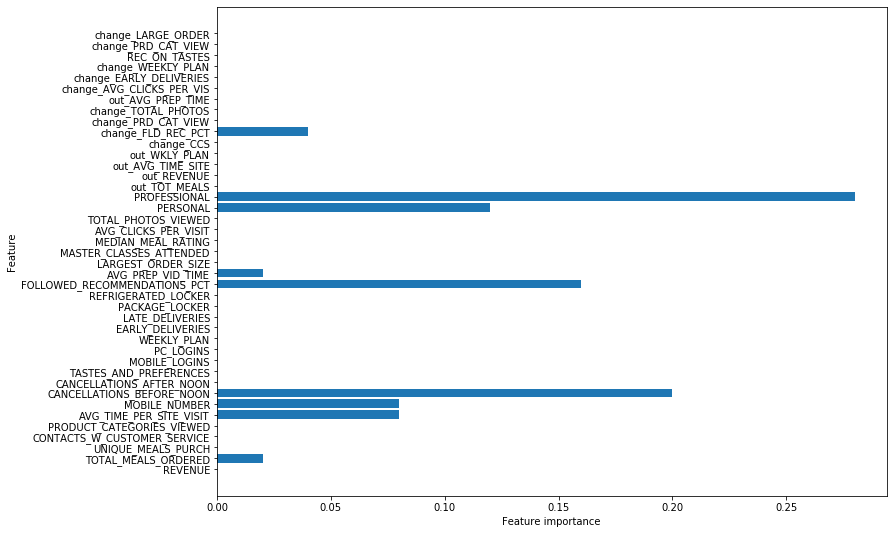

In [33]:
# AdaBoost feature importances (full)
plot_feature_importances(ada_fit, X_train_fulls)

In [34]:
# # Tuning ADA BOOST Classifier
# 
# # Declaring a hyperparameter space
# learn_space     = pd.np.arange(0.1, 1.6, 0.3)
# estimator_space = pd.np.arange(50, 400, 70)
# 
# # Creating a hyperparameter grid
# ada_param_grid = {'n_estimators'    : estimator_space,
#                   'learning_rate'   : learn_space}
# 
# # Instantiating the model object without hyperparameters
# ada_grid = AdaBoostClassifier(random_state = SEED)
# 
# # GridSearchCV object
# ada_cv = GridSearchCV(estimator  = ada_grid,
#                            param_grid = ada_param_grid,
#                            cv         = 3,
#                            scoring    = make_scorer(roc_auc_score,
#                                         needs_threshold = False))
# 
# # Fitting to the full dataset (due to cross-validation)
# ada_cv.fit(X_train_fulls, y_train_fulls)
# 
# # Printing the optimal parameters and best score
# print("Tuned Parameters  :", ada_cv.best_params_)
# print("Tuned Training AUC:", ada_cv.best_score_.round(4))

## Comparing Model Performance
From the following sets we want to select a model that performs well and has a testing and training score within 5% of each other.

In [35]:
# Appending to model_performance

print(f"""
Model                   Training Score    Testing Score    AUC
KNN Classifier full         {knn_train_acc}         {knn_test_acc}         {knn_auc}
Linear Regression full      {lr_full_train_acc}         {lr_full_test_acc}         {lr_full_auc}
Linear Regression sig       {lr_full_train_acc}         {lr_full_test_acc}         {lr_full_auc}
Decision Tree full          {dec_tree_full_train_acc}         {dec_tree_full_test_acc}         {dec_tree_full_auc}
Decision Tree rel           {dec_tree_rel_train_acc}         {dec_tree_rel_test_acc}         {dec_tree_rel_auc}
Random Forest full          {rf_full_train_acc}         {rf_full_test_acc}         {rf_full_auc}
Random Forest sig           {rf_rel_train_acc}         {rf_rel_test_acc}         {rf_rel_auc}        
Gradient Boosting full      {gbm_full_train_acc}         {gbm_full_test_acc}         {gbm_full_auc}
Gradient Boosting sig       {gbm_rel_train_acc}         {gbm_rel_test_acc}         {gbm_rel_auc}
Ada Boost full              {ada_train_acc}         {ada_test_acc}         {ada_auc}
""")


Model                   Training Score    Testing Score    AUC
KNN Classifier full         0.8115         0.7659         0.7227
Linear Regression full      0.8149         0.8029         0.7787
Linear Regression sig       0.8149         0.8029         0.7787
Decision Tree full          0.7759         0.7639         0.7687
Decision Tree rel           0.7587         0.7474         0.7687
Random Forest full          0.8314         0.7947         0.749
Random Forest sig           0.8136         0.7967         0.7471        
Gradient Boosting full      0.8314         0.7864         0.7633
Gradient Boosting sig       0.7834         0.7844         0.7804
Ada Boost full              0.8012         0.7988         0.7927



## Conclusion

Using an *AdaBoost Classification model* had the best area under the curve (AUC) with an AUC score **0.7927** and the training and testing accuracies are within 1% of each other. 

The most important features in this model were having a **PROFESSIONAL** email address, **CANCELLATIONS_BEFORE_NOON**, **FOLLOWED_RECOMMENDATIONS_PCT**, **PERSONAL** email address, and **MOBILE_NUMBER**.

To increase the cross sell success (CSS), it is important to discourage people from signing up with their junk email addresses. It is also wise to collect the mobile number. Both of these have a positive correlation with cross sell success. People with higher percentages of following recommendations are more likely to buy the wine as well. Focusing on having a successful recommendation plan through market and improvements in providing good recommendaitons should therefore improve the CSS.

Cancellations before noon have a negative correlation with CSS, so the business may do well to discourage these cancellations through strategies such as personalized customer service if it does not raise costs significantly. 